In [1]:
# for folders one level below the heirarchy
import sys
import os 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

## More dependencies
import scipy.fft as spfft
from scipy.ndimage import gaussian_filter1d as sp_gaussian_filter1d
from scipy.ndimage import affine_transform as sp_affine_transform
from scipy.ndimage import gaussian_filter as sp_gaussian_filter
from scipy.optimize import minimize
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product

cupyon=True

try:
    import cupy as cp
    import numpy as np
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
    from cupy.lib.stride_tricks import as_strided

except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    print("cupy not installed. Using numpy.")


In [60]:
## Global Variables
# Hardware-defined Constants. Note that all explicit variable values are in position (m), frequency (1/m), or time (s). Conversions are done explicitly to relevant time/distance scales.
aodaperture = 7.5e-3 # Aperture size of the AOD
soundvelocity = 650   # Sound velocity in the medium
cycletime = aodaperture / soundvelocity  # Time for one cycle of the waveform
focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

print("Cycletime in nanoseconds: ", cycletime * 1e9)

# Simulation Constants
numpix_frame = 1000
numpix_real = 4096
pixelsize_real = aodaperture / numpix_frame
aperturesize_real = numpix_real * pixelsize_real
aperturesize_fourier = wavelength * focallength / (pixelsize_real)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelsize_real*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)
print("Fourier space aperture in microns: ", aperturesize_fourier*10**6)

# Adjustable Variables
movementtime = 150*10**(-6) # Time for the movement of the AOD
timestep = cycletime / numpix_frame
print("Timestep in nanoseconds:", timestep * 10**9)
startlocation = 50*10**(-6) # Start location of the AOD in microns. 0 is set to the center of Fourier space.
endlocation = 150*10**(-6) # End location of the AOD in microns


polynomialbasis = 'Chebyshev'  # Basis for the polynomial fit
numcoefficients = 100

globalvariables = [aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients]
aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

### From the global variables, initialize the AWG waveform
numpix_waveform = int(movementtime / cycletime * numpix_frame) + 2* numpix_frame # Why is there a 2* cycletime here? To add on the initial and final stages of the AOD. We will only change the portion in the movement time and fix the ends.
AWGwaveform = cp.zeros(numpix_waveform)



Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  7.499999999999999
Fourier space spacing in microns:  0.18662109375000002
Fourier space aperture in microns:  764.4000000000001
Timestep in nanoseconds: 11.538461538461538
Tweezer starting positions: 49.99999999999999 microns or 5.668934240362814 MHz
Tweezer ending positions: 150.0 microns or 17.006802721088434 MHz


In [65]:

def initpath_linearramp(globalvariables):
    '''Initializes positions throughout the movementtime with an acceleration profile that is a linear ramp up for half the time then down for half the time that moves
    the atom from startlocation to endlocation.'''
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

    
    # Define the number of time steps
    num_steps = 1000
    total_time = movementtime
    time = np.linspace(0, total_time, num_steps)
    
    # Initial and final positions
    initial_position = startlocation * 10**6  # Convert to micrometers
    final_position = endlocation * 10**6  # Convert to micrometers
    D = final_position - initial_position
    
    # Calculate the constant acceleration needed
    a_max = (4 * D) / (total_time**2)  # Maximum acceleration
    
    # Initialize arrays for acceleration, velocity, position, and jerk
    accelerations = np.zeros(num_steps)
    velocities = np.zeros(num_steps)
    positions = np.zeros(num_steps)
    jerks = np.zeros(num_steps)
    
    # Calculate acceleration, velocity, and position for each time step
    half_time = total_time / 2
    half_steps = num_steps // 2
    time_step = total_time / num_steps
    
    for i in range(num_steps):
        if i <= half_steps:
            # Ramp up phase
            current_time = i * time_step
            accelerations[i] = a_max * (current_time / half_time)
        else:
            # Ramp down phase
            current_time = (i - half_steps) * time_step
            accelerations[i] = a_max * (1 - (current_time / half_time))

    def integrate_acceleration(acceleration, dt):
        velocity = np.cumsum(acceleration) * dt
        position = np.cumsum(velocity) * dt
        return velocity, position

    # Function to calculate jerk from acceleration
    def calculate_jerk(acceleration, dt):
        jerk = np.gradient(acceleration, dt)
        return jerk

    velocities, positions = integrate_acceleration(accelerations, time_step)
    jerks = calculate_jerk(accelerations, time_step)

    positions = positions / 10**6 + startlocation
    velocities = velocities / 10**6
    accelerations = accelerations / 10**6
    jerks = jerks / 10**6

    return positions,velocities,accelerations, jerks, time

def initpath_minimizejerk(globalvariables):
    '''Initializes positions throughout the movementtime that minimizes jerk.'''
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

    # Define the number of time steps and total time
    num_steps = 1000
    total_time = movementtime  # You may need to adjust this based on the problem's requirements
    time = np.linspace(0, 10, num_steps)
    time_out = np.linspace(0, total_time, num_steps)
    # Initial and final conditions
    initial_position = startlocation*(10**6)
    final_position = endlocation*(10**6)
    D = final_position - initial_position

    # Function to calculate velocity and position from acceleration
    def integrate_acceleration(acceleration, dt):
        velocity = np.cumsum(acceleration) * dt
        position = np.cumsum(velocity) * dt
        return velocity, position

    # Function to calculate jerk from acceleration
    def calculate_jerk(acceleration, dt):
        jerk = np.gradient(acceleration, dt)
        return jerk

    # Objective function to minimize jerk and achieve target position
    def objective(acceleration, dt):
        velocity, position = integrate_acceleration(acceleration, dt)
        jerk = calculate_jerk(acceleration, dt)
        jerk_cost = np.sum(jerk**2)  # Minimize the squared jerk
        position_error = (position[-1] - D)**2  # Ensure final position is D
        velocity_error = velocity[-1]**2  # Ensure final velocity is 0
        return jerk_cost + position_error + velocity_error

    # Initial guess for the acceleration profile
    initial_guess = np.zeros(num_steps)

    # Optimization constraints
    constraints = [
        {'type': 'eq', 'fun': lambda a: integrate_acceleration(a, time[1] - time[0])[1][-1] - D},  # Final position constraint
        {'type': 'eq', 'fun': lambda a: integrate_acceleration(a, time[1] - time[0])[0][-1]},     # Final velocity constraint
    ]

    # Perform the optimization
    result = minimize(objective, initial_guess, args=(time[1] - time[0]), constraints=constraints, method='SLSQP')

    # Extract the optimized acceleration profile
    optimized_acceleration = result.x
    optimized_velocity, optimized_position = integrate_acceleration(optimized_acceleration, time[1] - time[0])
    optimized_jerk = calculate_jerk(optimized_acceleration, time[1] - time[0])
    
    optimized_acceleration = optimized_acceleration / (10**6)
    optimized_velocity = optimized_velocity / (10**6)
    optimized_position = (optimized_position)/ (10**6) + startlocation
    optimized_jerk = optimized_jerk / (10**6)
    
    return optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time_out

def positionstofourier(positions, time, globalvariables):
    '''Converts positions from initialized paths onto pixels in the fourier plane, preserving accuracy by storing as floats. These will later be converted to desired
    spots on the AWG waveform.'''
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables
    framecenter = numpix_real / 2
    fourierpixels = (positions / pixelsize_fourier) + framecenter

    return fourierpixels, time

def fouriertopositions(fourierpixels, time, globalvariables):
    '''Converts positions from initialized paths onto pixels in the fourier plane, preserving accuracy by storing as floats. These will later be converted to desired
    spots on the AWG waveform.'''
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables
    framecenter = numpix_real / 2
    positions = (fourierpixels - framecenter)*pixelsize_fourier
    
    return positions, time   

def expand_position_array(time, position, globalvariables):
    '''
    Expands the position array to match the resolution of the AWGwaveform time array.
    
    Parameters:
        time (np.array): The array of time values corresponding to the position array.
        position (np.array): The array of position values.
        AWGwaveform (np.array): The higher resolution time array for the AWG waveform.
        
    Returns:
        np.array: The expanded position array.
    '''
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

    AWGtime = np.linspace(0,movementtime, int(movementtime / cycletime * numpix_frame))
    # Create an interpolation function based on the original time and position arrays
    interpolation_function = interp1d(tonumpy(time), tonumpy(position), kind='linear', fill_value='extrapolate')
    
    # Use the interpolation function to generate the expanded position array
    expanded_position = interpolation_function(tonumpy(AWGtime))
    
    return expanded_position, AWGtime

def realtofourier(inputarray):
    """
    Simulate the Fourier transform of a waveform.
    
    Parameters:
    inputarray (cp.ndarray): The input waveform.
    
    Returns:
    cp.ndarray: The Fourier transform of the input waveform.
    """
    # Perform the Fourier transform
    outputarray = cpfft.fftshift(cpfft.fft(cpfft.fftshift(inputarray), norm="ortho"))
    fourierintensity = cp.square (cp.abs(outputarray))
    return fourierintensity

def fouriertoreal(inputarray):
    """
    Simulate the Fourier transform of a waveform.
    
    Parameters:
    inputarray (cp.ndarray): The input waveform.
    
    Returns:
    cp.ndarray: The Fourier transform of the input waveform.
    """
    # Perform the Fourier transform
    outputarray = cpfft.ifftshift(cpfft.fft(cpfft.ifftshift(inputarray), norm="ortho"))
    fourierintensity = cp.square (cp.abs(outputarray))
    return fourierintensity

def initguess_continuouscosine(AWGwaveform, positions, time, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

    AWG_fourierspace = cp.zeros(len(AWGwaveform))
    fourierpixels, time = positionstofourier(positions, time, globalvariables)
    expanded_fourierpixels, expanded_time = expand_position_array(time, fourierpixels, globalvariables)
    AWG_fourierspace[numpix_frame: -numpix_frame] = tocupy(expanded_fourierpixels)
    frequency_t0 = fourierpixels[0]
    frequency_tF = fourierpixels[-1]
    AWG_fourierspace[0:numpix_frame] = frequency_t0
    AWG_fourierspace[-numpix_frame:] = frequency_tF
    AWG_time = cp.linspace(0, 1*len(AWGwaveform) / numpix_real, len(AWGwaveform))
    
    AWG_fourierspace = AWG_fourierspace - numpix_real // 2

    AWGwaveform_out = cp.cos(2*cp.pi*cp.cumsum(AWG_fourierspace) * (AWG_time[1] - AWG_time[0]))
    

    return AWGwaveform_out

def snapshot(cycle, globalvariables):
    '''Cycle here is non-zero padded section of length numpix_frame of the AWGwaveform.'''
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

    cycle = zeropadframe(cycle, globalvariables)
    return realtofourier(cycle)

def retrieveforces(AWGwaveform, globalvariables, timeperframe = 1):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

    num_snapshots = (len(AWGwaveform) - numpix_frame) // timeperframe + 1
    
    # Create a view of the input array with overlapping windows
    strides = (AWGwaveform.strides[0] * timeperframe, AWGwaveform.strides[0])
    shape = (num_snapshots, numpix_frame)
    snapshots = as_strided(AWGwaveform, shape=shape, strides=strides)    
    snapshots = cp.array([realtofourier(zeropadframe(snap, globalvariables)) for snap in snapshots])

    snapshots = calculateforces(snapshots)

    if timeperframe > 1:
        interpolated_snapshots = cp.zeros((num_snapshots + (num_snapshots - 1) * (timeperframe - 1), numpix_real), dtype=AWGwaveform.dtype)
        interpolated_snapshots[::timeperframe] = snapshots
        
        for i in range(1, timeperframe):
            interpolated_snapshots[i::timeperframe] = (snapshots[:-1] * (timeperframe - i) + snapshots[1:] * i) / timeperframe
        
        return interpolated_snapshots

    return snapshots

def retrievepotentials(AWGwaveform, globalvariables, timeperframe = 1):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

    num_snapshots = (len(AWGwaveform) - numpix_frame) // timeperframe + 1
    
    # Create a view of the input array with overlapping windows
    strides = (AWGwaveform.strides[0] * timeperframe, AWGwaveform.strides[0])
    shape = (num_snapshots, numpix_frame)
    snapshots = as_strided(AWGwaveform, shape=shape, strides=strides)    
    snapshots = cp.array([realtofourier(zeropadframe(snap, globalvariables)) for snap in snapshots])


    if timeperframe > 1:
        interpolated_snapshots = cp.zeros((num_snapshots + (num_snapshots - 1) * (timeperframe - 1), numpix_real), dtype=AWGwaveform.dtype)
        interpolated_snapshots[::timeperframe] = snapshots
        
        for i in range(1, timeperframe):
            interpolated_snapshots[i::timeperframe] = (snapshots[:-1] * (timeperframe - i) + snapshots[1:] * i) / timeperframe
        
        return interpolated_snapshots

    return snapshots

def calculateforces(potentials):
    forces = cp.zeros_like(potentials)
    forces = [gradient(potential) * potential for potential in potentials]
    return cp.array(forces)


def initdistribution_MaxwellBoltzmann(num_particles, trapenergy, atommass, globalvariables):
    """
    Generates a Maxwell-Boltzmann distribution of particles' positions and velocities.

    Parameters:
    - num_particles (int): Number of particles.
    - mass (float): Mass of each particle.
    - temperature (float): Temperature in Kelvin.
    - kb (float, optional): Boltzmann constant. Default is 1.38e-23 J/K.

    Returns:
    - positions (np.ndarray): Array of positions of particles.
    - velocities (np.ndarray): Array of velocities of particles.
    """
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables
       
    x0, time = positionstofourier(startlocation,0, globalvariables)
    
    # Standard deviation for velocity from Maxwell-Boltzmann distribution
    std_velocity = np.sqrt(2 * trapenergy / atommass)
    
    # Generating velocities
    velocities = np.random.normal(0, std_velocity, (num_particles,1)) 
    
    # Generating positions (assuming normal distribution centered at 0 with some spread)
    positions = np.random.normal(0, std_velocity/10, (num_particles,1)) +x0
    
    return positions, velocities



# quality of life
def gradient(arr):
    # Calculate the spacing between points
    dx = 1.0  # Assuming unit spacing for simplicity; adjust if needed
    
    # Compute the first derivative using central differences
    derivative = (cp.roll(arr, -1) - cp.roll(arr, 1)) / (2 * dx)
    
    # Handle boundaries with forward and backward differences
    derivative[0] = (arr[1] - arr[0]) / dx
    derivative[-1] = (arr[-1] - arr[-2]) / dx
    
    return cp.array(derivative)


def tonumpy(array):
    '''Checks if the input array is a CuPy array and converts it to a NumPy array if necessary.'''
    if isinstance(array, cp.ndarray):
        return cp.asnumpy(array)  # Convert CuPy array to NumPy array
    elif isinstance(array, np.ndarray):
        return array  # Already a NumPy array, return as is
    else:
        raise TypeError("Input is neither a NumPy nor a CuPy array")

def tocupy(array):
    '''Checks if the input array is a NumPy array and converts it to a CuPy array if necessary.'''
    if isinstance(array, np.ndarray):
        return cp.asarray(array)  # Convert NumPy array to CuPy array
    elif isinstance(array, cp.ndarray):
        return array  # Already a CuPy array, return as is
    else:
        raise TypeError("Input is neither a NumPy nor a CuPy array")

def zeropadframe(frame, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables

    paddedframe = cp.zeros(numpix_real)
    paddedframe[(numpix_real - numpix_frame) // 2: (numpix_real + numpix_frame) // 2] = frame
    return paddedframe

def micronstoMHz(startlocation_microns, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables
    frequencyposition_meters = startlocation_microns
    frequencyposition_pixel = positionstofourier(frequencyposition_meters,0, globalvariables)[0]
    acousticwavelength_pixel = (numpix_real)/(frequencyposition_pixel - numpix_real // 2)
    acousticwavelength_meters = acousticwavelength_pixel * pixelsize_real
    frequencyposition_MHz = soundvelocity / acousticwavelength_meters
    return frequencyposition_MHz    

print("Tweezer starting positions:", startlocation*10**6, "microns or", micronstoMHz(startlocation, globalvariables) /10**6, "MHz")
print("Tweezer ending positions:", endlocation*10**6, "microns or", micronstoMHz(endlocation, globalvariables) /10**6, "MHz")
print("One micron corresponds to", micronstoMHz(1e-6, globalvariables) /10**6, "MHz")

Tweezer starting positions: 49.99999999999999 microns or 5.668934240362814 MHz
Tweezer ending positions: 150.0 microns or 17.006802721088434 MHz
One micron corresponds to 0.1133786848072586 MHz


In [4]:
num_particles = 1000
atommass = 1 # Mass of the atom
tweezerdepth = 10 MHz


In [5]:
optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time = initpath_linearramp(globalvariables)
# optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time = initpath_minimizejerk(globalvariables)
fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)
expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)

AWGinitguesscosine = initguess_continuouscosine(AWGwaveform, optimized_position, time, globalvariables)
potentials = retrievepotentials(AWGinitguesscosine, globalvariables, 1)
forces = retrieveforces(AWGinitguesscosine, globalvariables, 1)

(array([  1.,  22.,  60., 159., 233., 232., 170.,  80.,  36.,   7.]),
 array([2315.87658942, 2315.88562853, 2315.89466764, 2315.90370675,
        2315.91274586, 2315.92178497, 2315.93082408, 2315.93986319,
        2315.9489023 , 2315.95794141, 2315.96698052]),
 <BarContainer object of 10 artists>)

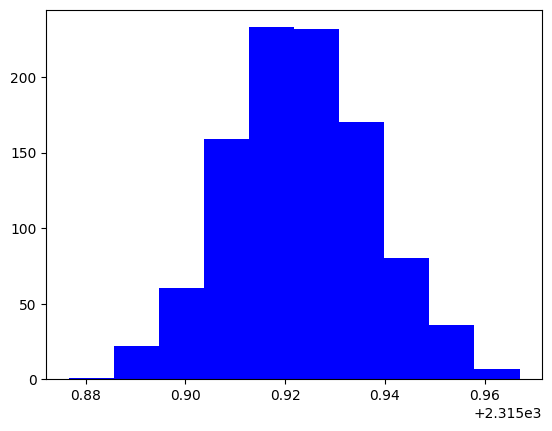

In [47]:
initial_x_dx= initdistribution_MaxwellBoltzmann(num_particles, 0.01, atommass, globalvariables)
plt.hist(initial_x_dx[0], color='blue')


In [53]:

def montecarlo(forces, globalvariables, initialdistribution, atommass):
    ''' Monte Carlo simulation of a distribution of particles in a potential landscape.'''
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, polynomialbasis, numcoefficients = globalvariables
        # Assuming that force is in units of kg*m/s^2, and mass is in kg, then acceleration is in m/s^2
    
    # Need to convert force from units of meters to units of pixels to make things computationally efficient
    
    ddx = forces / atommass
    x0 = tocupy(initialdistribution[0])
    dx0 = tocupy(initialdistribution[1])
    x_t1 = x0
    dx_t1 = dx0
    x_t2 = x0
    dx_t2 = dx0
    
    for iteration in range(len(ddx)):
        ddx_frame = ddx[iteration]
        ddx_t1 = tocupy(np.interp(tonumpy(x_t1), np.arange(numpix_real), tonumpy(ddx_frame)))
        dx_t2 = dx_t1 + ddx_t1 * timestep
        x_t2 = x_t1 + dx_t1 * timestep
        
        dx_t1 = dx_t2
        x_t1 = x_t2

    
    return x_t2, dx_t2, ddx_t1


xout, vout, accel = montecarlo(forces, globalvariables, initial_x_dx, 0.00000000002)

2315.9225536368394
2851.767660910518


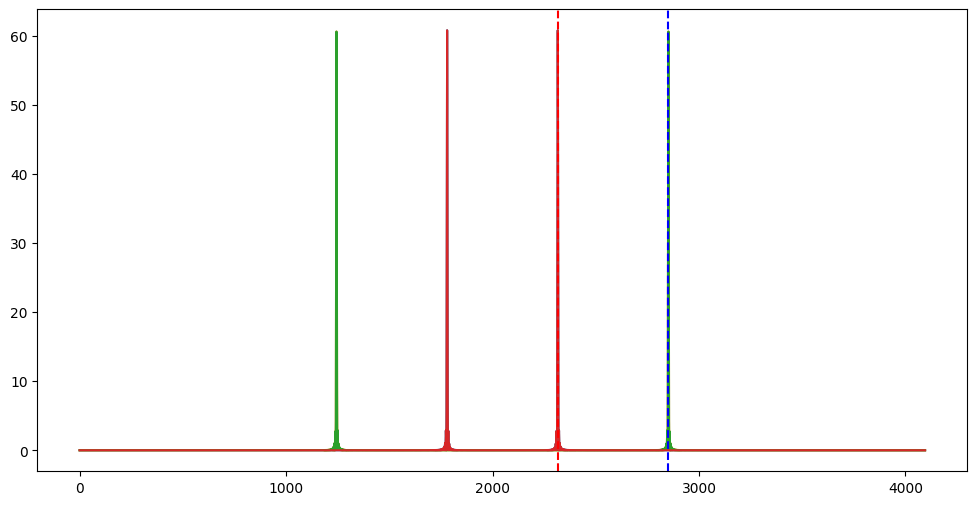

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[0:1000],globalvariables)).get())
plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[-1000:],globalvariables)).get())
plt.plot(potentials[-1].get())
plt.plot(potentials[0].get())


plt.axvline(x=positionstofourier(startlocation, 0, globalvariables)[0], color='red', linestyle='--')
plt.axvline(x=positionstofourier(endlocation, 0, globalvariables)[0], color='blue', linestyle='--')
print(positionstofourier(startlocation, 0, globalvariables)[0])
print(positionstofourier(endlocation, 0, globalvariables)[0])


In [ ]:
aodaperture = 7.5e-3 # Aperture size of the AOD
soundvelocity = 650   # Sound velocity in the medium
cycletime = aodaperture / soundvelocity  # Time for one cycle of the waveform
focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

print("Cycletime in nanoseconds: ", cycletime * 1e9)

# Simulation Constants
numpix_frame = 1000
numpix_real = 4096
pixelsize_real = aodaperture / numpix_frame
aperturesize_real = numpix_real * pixelsize_real
aperturesize_fourier = wavelength * focallength / (pixelsize_real)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelsize_real*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)
print("Fourier space aperture in microns: ", aperturesize_fourier*10**6)

# Adjustable Variables
movementtime = 150*10**(-6) # Time for the movement of the AOD
timestep = cycletime / numpix_frame
print("Timestep in nanoseconds:", timestep * 10**9)
startlocation = 50*10**(-6) # Start location of the AOD in microns. 0 is set to the center of Fourier space.
endlocation = 150*10**(-6) # End location of the AOD in microns


polynomialbasis = 'Chebyshev'  # Basis for the polynomial fit
numcoefficients = 100

(array([ 6., 13., 15., 14., 13., 22., 20., 22., 11., 23., 11., 16., 21.,
        14., 14., 19., 21., 26., 21., 15.,  9.,  7., 13., 15., 16.,  9.,
        12., 14., 12.,  9.,  8., 10.,  7., 13.,  7.,  4.,  5.,  9.,  6.,
         3.,  2.,  6.,  4.,  3.,  2.,  5.,  2.,  5.,  1.,  3.,  4.,  1.,
         1.,  2.,  1.,  3.,  1.,  1.,  1.,  2.,  2.,  3.,  7.,  5.,  4.,
         3.,  5.,  4.,  8., 13.,  5., 11.,  6.,  4.,  4.,  4., 12.,  8.,
         7., 10.,  9., 17., 13., 11., 16., 11., 14., 16., 14., 18., 12.,
        11., 11., 24., 23., 14., 20., 25., 16.,  5.]),
 array([1850.0169175 , 1859.68914775, 1869.36137799, 1879.03360824,
        1888.70583848, 1898.37806873, 1908.05029897, 1917.72252922,
        1927.39475947, 1937.06698971, 1946.73921996, 1956.4114502 ,
        1966.08368045, 1975.7559107 , 1985.42814094, 1995.10037119,
        2004.77260143, 2014.44483168, 2024.11706192, 2033.78929217,
        2043.46152242, 2053.13375266, 2062.80598291, 2072.47821315,
        2082.1504434 , 209

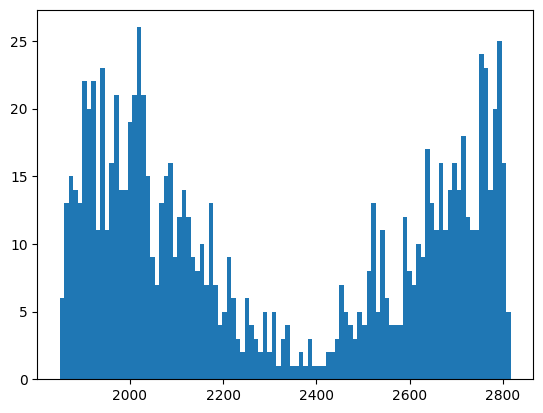

In [56]:
plt.hist(xout.get(), bins=100)

(array([204., 146.,  95.,  55.,  18.,  29.,  69.,  89., 158., 137.]),
 array([-5910952.99326956, -4679133.04912816, -3447313.10498676,
        -2215493.16084536,  -983673.21670396,   248146.72743744,
         1479966.67157884,  2711786.61572024,  3943606.55986163,
         5175426.50400303,  6407246.44814443]),
 <BarContainer object of 10 artists>)

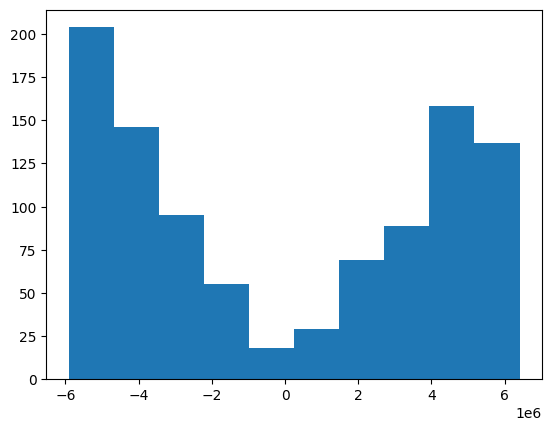

In [37]:
plt.hist(vout.get())

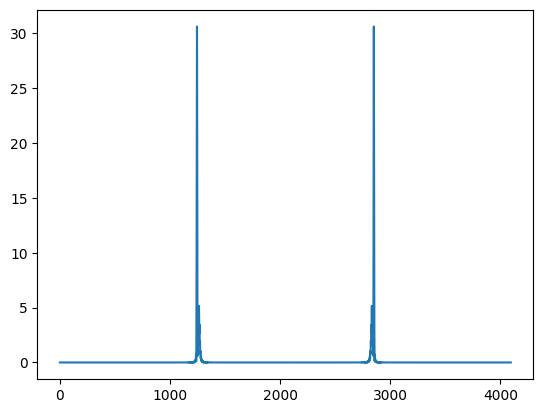

In [14]:
plt.plot(potentials[-400].get())




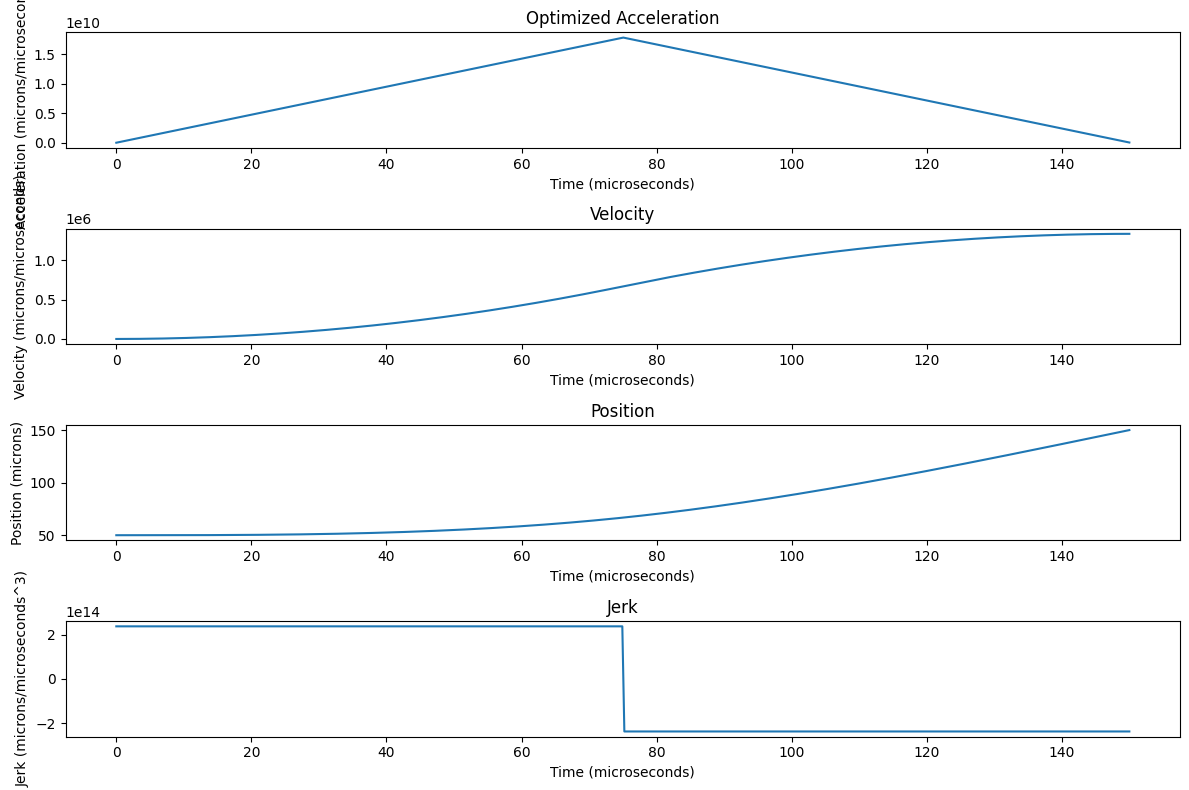

In [15]:
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(time * 10**6, optimized_acceleration * 10**6)
plt.title('Optimized Acceleration')
plt.xlabel('Time (microseconds)')
plt.ylabel('Acceleration (microns/microseconds^2)')

plt.subplot(4, 1, 2)
plt.plot(time* 10**6, optimized_velocity* 10**6)
plt.title('Velocity')
plt.xlabel('Time (microseconds)')
plt.ylabel('Velocity (microns/microseconds)')

plt.subplot(4, 1, 3)
plt.plot(time* 10**6, optimized_position* 10**6)
plt.title('Position')
plt.xlabel('Time (microseconds)')
plt.ylabel('Position (microns)')

plt.subplot(4, 1, 4)
plt.plot(time* 10**6, optimized_jerk* 10**6)
plt.title('Jerk')
plt.xlabel('Time (microseconds)')
plt.ylabel('Jerk (microns/microseconds^3)')

plt.tight_layout()
plt.show()